### Preprocessing

- exclude useless features (constants/trivials)
- divide features in categorical/quantitative
- fill missing values
    - `intensity` is estimated using `std`
    - `NaN` values for other features are converted to -1

In [92]:
import pandas as pd
import intensity_fill

df = pd.read_csv("ravdess_features.csv")
display(df)
excluded = [
    "modality",
    "channels",
    "frame_rate",
    "frame_width",
    "sample_width",
    "stft_max",
    "frame_count",
    "length_ms",
]
# Features' exclusion
df.drop(columns=excluded, inplace=True)

# Categotical/quantitative division
categorical = ["sex", "emotion", "emotional_intensity", 
                "vocal_channel", "statement", "actor",
                "repetition", 
                #"channels", "sample_width",
            ]
quantitative = [feature for feature in df.columns if not feature in categorical]


# Conversion to categorical codes
cat_id = dict(zip(categorical, categorical))
for field in categorical:
    # Sets NaN to nont available (new category)
    df[field].fillna("N/A", inplace=True)
    df[field] = pd.Categorical(df[field])
    # Saves categorical mapping
    cat_id[field] = dict(enumerate(df[field].cat.categories ))
    df[field] = pd.Categorical(df[field]).codes

# Fill intensity
df = intensity_fill.fill_intensity(df)
df.sort_values(by=['sex','vocal_channel', 'emotional_intensity', ], inplace=True)

with pd.option_context('display.max_rows', 10, 'display.max_columns', None):  # more options can be specified also
    display(df)

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,channels,sample_width,...,stft_min,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew
0,audio-only,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F,1,2,...,0.000000,1.0,-1.215025,0.403514,3.844916e-07,0.014482,-0.128632,0.138947,9.406061,0.273153
1,audio-only,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F,1,2,...,0.000000,1.0,-1.384174,0.290905,-7.149491e-08,0.020417,-0.305725,0.263062,19.564187,0.292157
2,audio-only,NaN,happy,strong,Dogs are sitting by the door,2nd,16.0,F,1,2,...,0.000000,1.0,-1.242947,0.470350,2.429985e-06,0.024317,-0.137482,0.166351,4.881241,0.302659
3,audio-only,NaN,surprised,normal,Kids are talking by the door,1st,14.0,F,1,2,...,0.000000,1.0,-1.445318,0.274756,2.373929e-07,0.003561,-0.027374,0.024078,13.040259,-0.081014
4,audio-only,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F,1,2,...,0.000000,1.0,-1.366742,0.318926,8.454691e-07,0.027522,-0.192169,0.242676,7.485109,0.414872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,audio-only,speech,calm,strong,Kids are talking by the door,1st,23.0,M,1,2,...,0.000000,1.0,-1.075888,-0.310088,9.367040e-07,0.005260,-0.039856,0.052399,9.551363,0.759247
2448,audio-only,speech,calm,normal,Dogs are sitting by the door,1st,23.0,M,1,2,...,0.000000,1.0,-1.026071,-0.408018,4.614221e-07,0.006836,-0.064178,0.084045,22.517991,1.073633
2449,audio-only,song,sad,strong,Dogs are sitting by the door,2nd,23.0,M,1,2,...,0.000000,1.0,-1.473789,0.130310,-8.219263e-06,0.015384,-0.093079,0.097260,4.964319,-0.005821
2450,audio-only,speech,surprised,normal,Kids are talking by the door,1st,NaN,M,1,2,...,0.001565,1.0,-1.277117,-0.242668,-4.400898e-06,0.005182,-0.057556,0.052002,13.855588,-0.110966


/home/djanloo/Desktop/dynamiting/UNDERSTANDING/intensity_fill.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.intensity[df.intensity.isna()] = I_from_std(df["std"][df.intensity.isna()])


,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,intensity,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_kur,stft_skew,mean,std,min,max,kur,skew
3,0,7,0,1,0,13,0,-49.019839,11617,-36.059555,159.725160,-842.94635,190.03609,5376.446478,4053.663073,0.000000,12048.223893,-1.497765,0.098802,0.407277,0.360552,0.000000,-1.445318,0.274756,2.373929e-07,0.003561,-0.027374,0.024078,13.040259,-0.081014
48,0,1,0,0,0,15,0,-36.003695,16911,-33.291420,136.688110,-773.50650,162.08710,4842.304145,3310.679581,0.000000,12036.184978,-1.230667,0.434030,0.367649,0.356513,0.000000,-1.252885,0.486288,-1.988432e-06,0.015731,-0.074493,0.088593,3.678163,-0.031589
238,0,5,0,1,1,24,0,-39.182949,8545,-36.822160,141.587830,-794.19434,145.29167,4383.180625,3865.124874,0.000000,12082.265408,-0.923374,0.747866,0.317424,0.367650,0.000000,-1.115913,0.714722,-5.618335e-07,0.010996,-0.064148,0.065033,5.004379,-0.160188
250,0,0,0,0,0,9,0,-28.063603,21445,-27.003395,109.497890,-626.54370,146.80023,4458.862755,2575.900669,738.301363,10911.825653,-0.375101,0.863578,0.355533,0.333359,0.000011,-0.874677,0.693013,1.248202e-06,0.039544,-0.239136,0.253113,6.224651,0.184372
279,0,3,0,1,1,7,0,-36.811776,9096,-24.589018,133.413800,-749.52124,221.62567,3942.257084,2862.036465,98.828640,10503.456321,-0.883005,0.585903,0.536674,0.336190,0.000187,-1.410063,-0.106975,-8.540023e-06,0.014450,-0.106934,0.105438,6.944076,-0.303220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2428,2,7,1,1,0,4,1,-43.460545,15672,-29.170189,145.774120,-809.66986,190.20998,6423.394709,3339.501973,1204.061582,11998.048217,-1.477532,-0.016264,0.566232,0.324269,0.000698,-1.246835,-0.296592,7.880060e-06,0.006718,-0.046509,0.047943,7.685889,-0.549770
2429,2,0,1,0,0,24,1,-23.350695,12592,-23.191303,103.810550,-595.85960,175.24634,6425.902510,3506.448391,1312.357425,12056.769834,-1.533138,0.223184,0.554356,0.342817,0.000853,-1.317451,-0.356614,2.132478e-05,0.067996,-0.666748,0.711151,9.495287,0.202383
2430,2,3,1,0,1,24,1,-26.182964,12913,-26.236550,111.367516,-621.08453,184.78807,5781.926973,2857.521965,1489.165574,11573.656845,-1.112142,0.241875,0.453681,0.323142,0.000307,-1.194655,0.214588,7.268994e-06,0.048731,-0.336334,0.499329,9.615860,0.380695
2445,2,7,1,0,0,24,1,-40.716213,7778,-25.815453,147.116780,-798.65370,214.56970,4645.862618,3055.279038,511.528673,10919.537644,-1.178478,0.421965,0.575689,0.315758,0.000314,-1.256183,-0.240707,3.096644e-05,0.009144,-0.100067,0.124420,23.292300,0.226566


5


/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


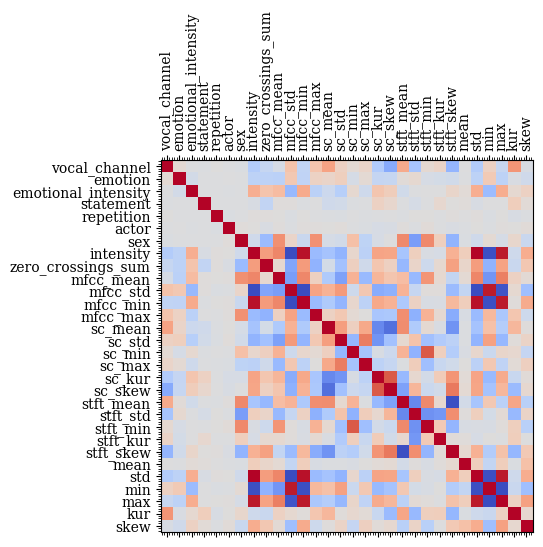

In [93]:
from matplotlib import pyplot as plt
plt.matshow(df.corr(method="spearman"), cmap="coolwarm")
plt.xticks(range(len(df.columns)), labels=df.columns, 
            rotation=90, font={"size":10, "family":"serif"} )
plt.yticks(range(len(df.columns)), labels=df.columns, 
            rotation=0, font={"size":10, "family":"serif"} )
print(5)

### Normalization

([<matplotlib.axis.XTick at 0x7f3029dd4130>,
 [Text(1, 0, 'intensity'),
  Text(2, 0, 'zero_crossings_sum'),
  Text(3, 0, 'mfcc_mean'),
  Text(4, 0, 'mfcc_std'),
  Text(5, 0, 'mfcc_min'),
  Text(6, 0, 'mfcc_max'),
  Text(7, 0, 'sc_mean'),
  Text(8, 0, 'sc_std'),
  Text(9, 0, 'sc_min'),
  Text(10, 0, 'sc_max'),
  Text(11, 0, 'sc_kur'),
  Text(12, 0, 'sc_skew'),
  Text(13, 0, 'stft_mean'),
  Text(14, 0, 'stft_std'),
  Text(15, 0, 'stft_min'),
  Text(16, 0, 'stft_kur'),
  Text(17, 0, 'stft_skew'),
  Text(18, 0, 'mean'),
  Text(19, 0, 'std'),
  Text(20, 0, 'min'),
  Text(21, 0, 'max'),
  Text(22, 0, 'kur'),
  Text(23, 0, 'skew')])

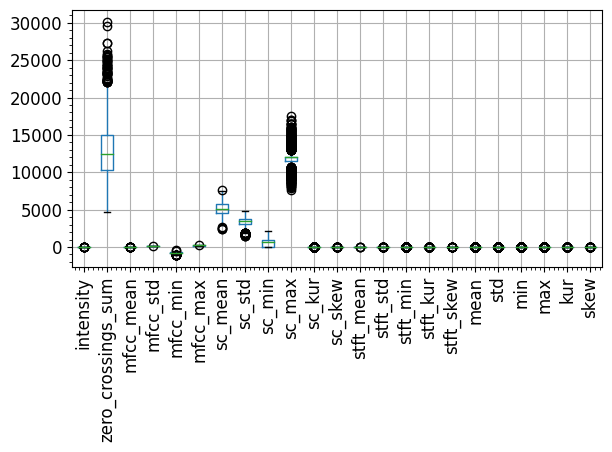

In [94]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
from pandas import DataFrame
scaler = StandardScaler()

X = df[quantitative].values
# X = scaler.fit_transform(X)
DataFrame(X).boxplot()
plt.xticks(range(1, 1+len(quantitative)), labels=quantitative, rotation=90)

Manifold knn representation

In [5]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
k = len(X)
A = kneighbors_graph(X,k, mode='distance', include_self=True)
adj = A.toarray()
plt.imshow(adj)
plt.colorbar()

This shows that the distances in the male subgroup are smaller than the inter-group average distance.

In [ ]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2, metric=True).fit_transform(X)

Text(0.5, 0.98, 'MultiDimensional Scaling (nonmetric)')

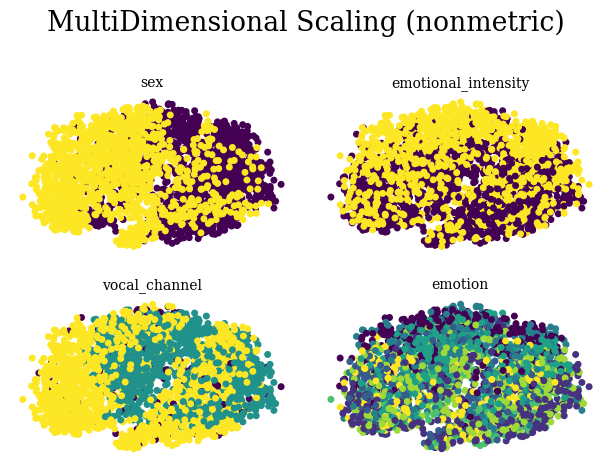

In [ ]:
fig, axes = plt.subplots(2,2)
axes = axes.flatten()
fields = ["sex", "emotional_intensity", "vocal_channel", "emotion"]
for ax, field in zip(axes, fields):
    ax.scatter(embedding[:,0], embedding[:,1], c=df[field])
    ax.set_title(field, font={"size":10, "family":"serif"})
    ax.axis("off")
fig.suptitle("MultiDimensional Scaling (nonmetric)", font={ "family":"serif"})

# UMAP

(-8.737056279182434, 14.257645630836487, 3.6071460008621217, 12.26030900478363)

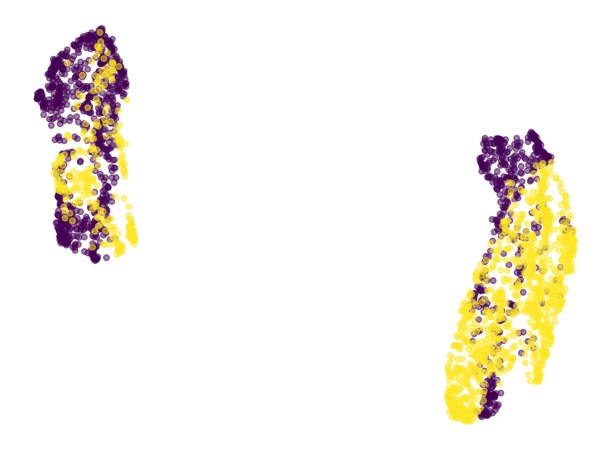

In [95]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
import umap 

X = df[quantitative].values
scaler = QuantileTransformer() # MinMaxScaler()
X = scaler.fit_transform(X)
reducer = umap.UMAP(n_neighbors=100)
embedding = reducer.fit_transform(X)
plt.scatter(embedding[:,0], embedding[:,1], c=df.sex, alpha=0.5)
plt.axis("off")

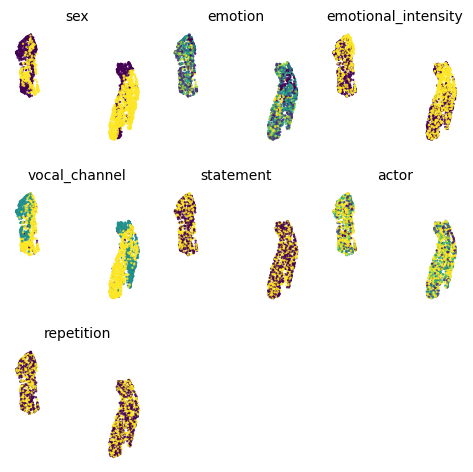

In [96]:
fig, axes = plt.subplots(3,3 , figsize=(5,5))
axes = axes.flatten()

for ax in axes:
    ax.axis("off")

for i in range(len(axes)):
    if i < len(categorical):
        axes[i].scatter(embedding[:,0], embedding[:,1], c=df[categorical[i]], alpha=0.8, s=0.5)
        axes[i].set_title(f"{categorical[i]}", font={"size":10})


We drop the analysis of `repetition`, `actor` and `statement` by now

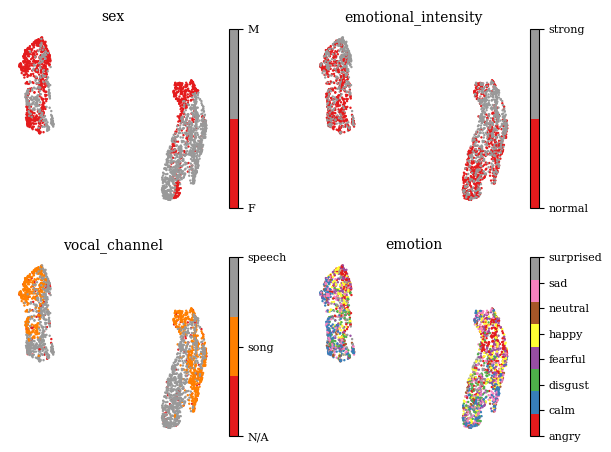

In [97]:
from matplotlib import cm

good_ones = ["sex", "emotional_intensity", "vocal_channel", "emotion"]

fig, axes = plt.subplots(2,2)
axes = axes.flatten()

for ax, cat in zip(axes, good_ones):
    cmap = cm.get_cmap("Set1", len(cat_id[cat]))
    mappable = ax.scatter(embedding[:,0], embedding[:,1], c=df[cat],
                cmap=cmap, alpha=1.0, s=0.5)
    ax.set_title(f"{cat}", font={"size":10, "family":"serif"})
    cbar = fig.colorbar(mappable, ax=ax)
    cbar.ax.set_yticks(list(cat_id[cat].keys()))
    cbar.ax.set_yticklabels(cat_id[cat].values(), font={"size":8, "family":"serif"})
    cbar.ax.tick_params(axis='y', which='minor', right=False)
    ax.axis("off")
fig.tight_layout()
plt.savefig("UMAP.pdf")


## ISOMAP and Minkowski _p_

It can be seen that when $p=1$ ISOMAP shows a big unique spot while when $p=\infty$ even isomap shows two distinct topological areas _even with a standard scaler_


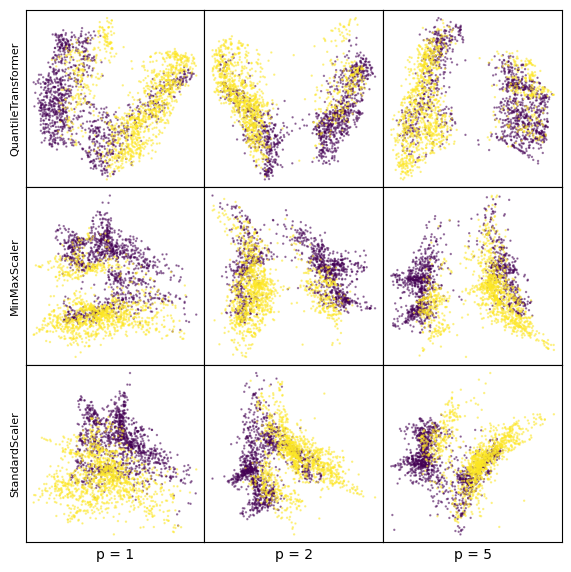

In [98]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
from sklearn.manifold import Isomap

scalers = [QuantileTransformer(), MinMaxScaler(), StandardScaler()]
ps = [1,2,5]

fig, axes = plt.subplots(len(scalers),len(ps), figsize=(6,6),gridspec_kw = {'wspace':0, 'hspace':0})

for i, scaler in enumerate(scalers):
    for j, p in enumerate(ps):
        X = df[quantitative].values
        X = scaler.fit_transform(X)
        S = Isomap(n_neighbors=5, p=p).fit_transform(X)
        axes[i,j].scatter(S[:,0], S[:,1], c=df.sex, alpha=0.5, s=0.5)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        
        if j == 0:
            axes[i,j].set_ylabel(str(scaler.__class__).split(".")[-1][:-2], font={"size":8})
        if i==2:
            axes[i,j].set_xlabel(f"p = {p}", font={"size":10})
        # axes[i,j].axis("off")
plt.show()

This reinforces the hypothesis of correctness of UMAP. Since the two blocks seems more manifest as p increases (that is to say, in _max_ norm) it is probable that one feature is causing this.

I will try to do the same excluding one feature at a time.

In [122]:
import numpy as np
features = quantitative.append(categorical)

X = QuantileTransformer().fit_transform(df[quantitative].values)
S = Isomap(n_neighbors=5, p=5).fit_transform(X)

n = int(np.sqrt(len(features)))+1

fig, axes = plt.subplots(n,n,gridspec_kw = {'wspace':0, 'hspace':0})
axes = axes.flatten()

for ax in axes:
    ax.axis("off")

for feat, ax, cols in zip(features, axes, X.T):
    ax.scatter(S[:,0], S[:,1], c=cols, s=0.4, alpha=0.5)
    ax.set_title(feat, font={"size":6})
plt.show()

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/pandas/core/common.py:245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


TypeError: unhashable type: 'list'

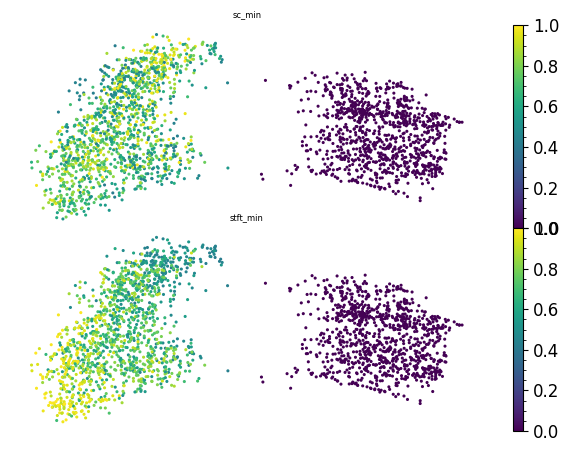

In [100]:
import numpy as np
features = ["sc_min", "stft_min"]

X = QuantileTransformer().fit_transform(df[quantitative].values)
S = Isomap(n_neighbors=5, p=5).fit_transform(X)

n = int(np.sqrt(len(features)))+1

fig, axes = plt.subplots(2,gridspec_kw = {'wspace':0, 'hspace':0})
axes = axes.flatten()

for ax in axes:
    ax.axis("off")
colors = QuantileTransformer().fit_transform(df[features]).T
for feat, ax, c in zip(features, axes, colors):
    u=ax.scatter(S[:,0], S[:,1], c=c, s=1.5)
    ax.set_title(feat, font={"size":6})
    fig.colorbar(mappable=u, ax=ax)
plt.show()

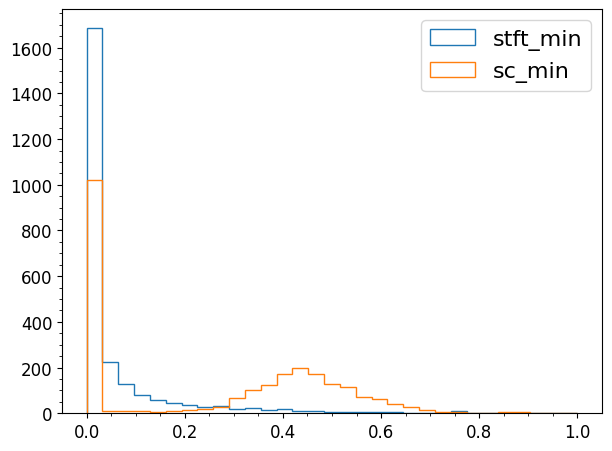

In [101]:
shit = {"histtype":"step", "bins":int(4*np.log(len(df)))}
sc_min = df.sc_min
sc_min = (sc_min - min(sc_min))/(max(sc_min) - min(sc_min))

stft_min = df.stft_min
stft_min = (stft_min - min(stft_min))/(max(stft_min) - min(stft_min))

plt.hist( stft_min,  **shit, label="stft_min")
plt.hist(sc_min,  **shit, label="sc_min")
plt.legend()

print()

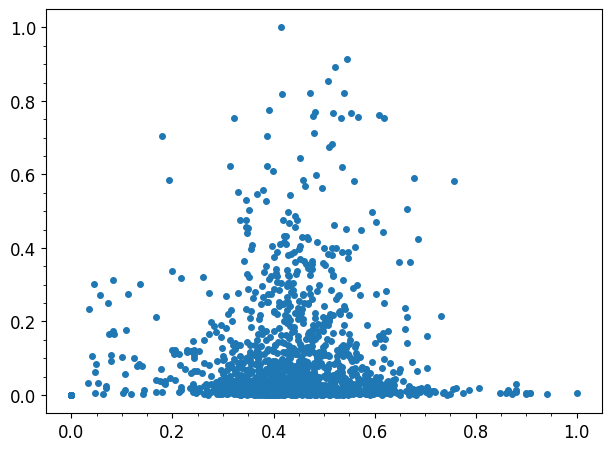

In [102]:
plt.scatter(sc_min, stft_min)

Try Umap again without the problematic columns

In [113]:
X = df[quantitative].drop(columns = ["sc_min", "stft_min"]).values
scaler = QuantileTransformer() # MinMaxScaler()
X = scaler.fit_transform(X)
reducer = umap.UMAP(n_neighbors=10)
embedding = reducer.fit_transform(X)

(-1.3656644433736802,
 13.66992618739605,
 1.5379607200622558,
 12.151458072662354)

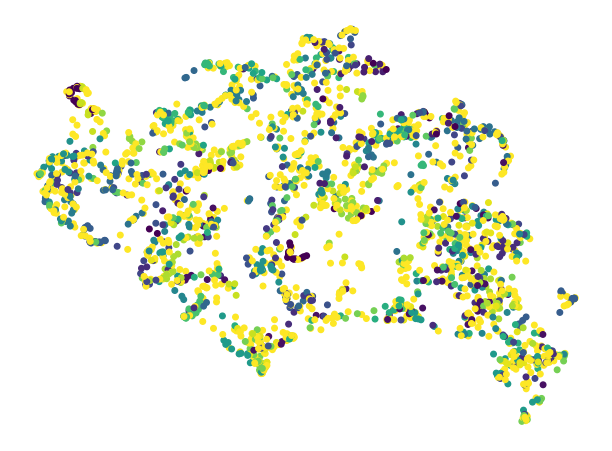

In [120]:
plt.scatter(embedding[:,0], embedding[:,1], c=df.actor)
plt.axis("off")

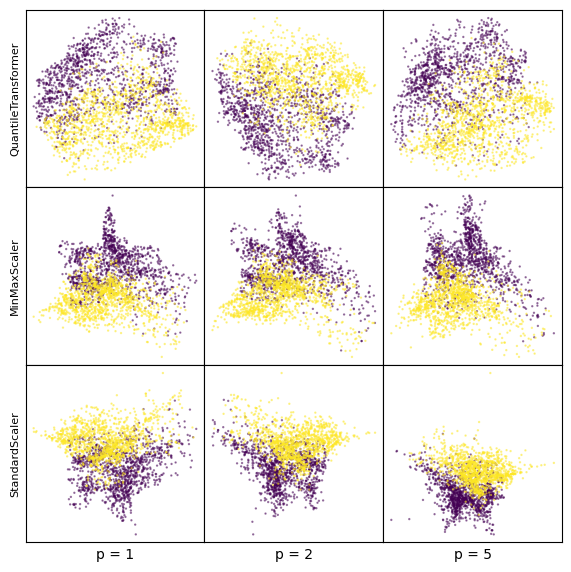

In [121]:
scalers = [QuantileTransformer(), MinMaxScaler(), StandardScaler()]
ps = [1,2,5]

fig, axes = plt.subplots(len(scalers),len(ps), figsize=(6,6),gridspec_kw = {'wspace':0, 'hspace':0})

for i, scaler in enumerate(scalers):
    for j, p in enumerate(ps):
        X = df[quantitative].drop(columns=["sc_min", "stft_min"]).values
        X = scaler.fit_transform(X)
        S = Isomap(n_neighbors=5, p=p).fit_transform(X)
        axes[i,j].scatter(S[:,0], S[:,1], c=df.sex, alpha=0.5, s=0.5)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        
        if j == 0:
            axes[i,j].set_ylabel(str(scaler.__class__).split(".")[-1][:-2], font={"size":8})
        if i==2:
            axes[i,j].set_xlabel(f"p = {p}", font={"size":10})
        # axes[i,j].axis("off")
plt.show()